# Tick library - guide and testing

## Python Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xlwings as xw
import itertools

## Tick Imports

### Simulation

In [2]:
from tick.hawkes import SimuHawkes, SimuHawkesMulti

#### Non-parametric

In [3]:
from tick.base import TimeFunction
from tick.hawkes import HawkesKernelTimeFunc

#### Parametric

In [4]:
from tick.hawkes import HawkesKernelSumExp

### Learners

#### Non-parametric

In [5]:
from tick.hawkes import HawkesEM, HawkesBasisKernels

#### Parametric

In [6]:
from tick.hawkes import HawkesSumExpKern, HawkesSumGaussians

### Plotting kernels

In [7]:
from tick.plot import plot_timefunction
from tick.plot import plot_point_process
from tick.plot import plot_hawkes_kernel_norms, plot_hawkes_kernels
from tick.plot import plot_basis_kernels

## Defining Time Functions

In [8]:
support = 4

#### Using a function

In [9]:
def g1(t):
    return 0.7 * 0.5 * 10 * np.exp(-0.5 * 10 * t)

Introducing a latency with heaviside

In [18]:
def g2(t):
    return 0.7 * 0.5 * 10 * np.exp(-0.5 * 10 * (t - 1))\
        * np.heaviside(t -1, 1) # To ensure zero before t0=1

In [11]:
xgrid = np.linspace(0, support, 40+1)

In [16]:
tf1 = TimeFunction((xgrid, g1(xgrid)), inter_mode=TimeFunction.InterLinear)

In [13]:
tf2 = TimeFunction((xgrid, g2(xgrid)), inter_mode=TimeFunction.InterConstRight)

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:113: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


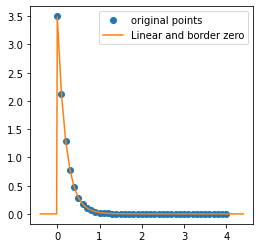

In [17]:
plot_timefunction(tf1)

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:113: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


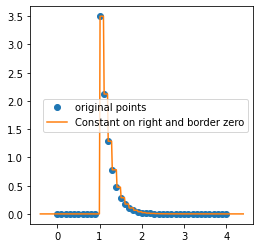

In [15]:
plot_timefunction(tf2)

### Creating a complete function with latency, linear interpolation and a custom grid

In [98]:
def time_func(f, support, t0=0, steps=1000):
    t_values = np.linspace(0, support, steps+1)
    y_values = f(t_values - t0) * np.heaviside(t_values - t0, 1)
    return TimeFunction(values=(t_values, y_values),
                        border_type=TimeFunction.Border0,
                        inter_mode=TimeFunction.InterLinear)

In [99]:
tf_1 = time_func(g1, 4)

In [100]:
tf_2 = time_func(g1, 4, 1)

In [101]:
print([[tf_1.value(0), tf_1.value(1)], [tf_2.value(1), tf_2.value(2)]])

[[3.5, 0.023582814496799394], [3.4999999999017244, 0.02358281449679965]]

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:113: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


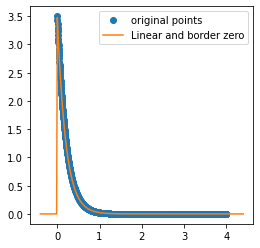

In [102]:
plot_timefunction(tf_1)

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(4, 4))
/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_timefunction.py:113: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


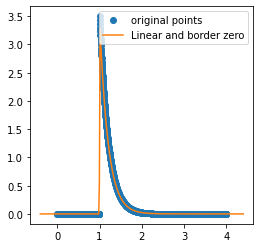

In [103]:
plot_timefunction(tf_2)

## Defining Non-parametric Kernels

In [104]:
kernel_1 = HawkesKernelTimeFunc(tf_1)

In [105]:
kernel_2 = HawkesKernelTimeFunc(tf_2)

## Defining Parametric Kernels

In [108]:
kernel_sumexp = HawkesKernelSumExp(
    intensities=np.array([0.1, 0.2, 0.1]),
    decays=np.array([1.0, 3.0, 7.0]))

## Simulations

### SimuHawkes

In [117]:
hawkes = SimuHawkes(n_nodes=1, end_time=40, seed=1398)
hawkes.set_kernel(0, 0, kernel_sumexp)
hawkes.set_baseline(0, 1.)

In [118]:
dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

----------------------------------------
Launching simulation using SimuHawkes...
Done simulating using SimuHawkes in 7.31e-03 seconds.


In [121]:
timestamps = hawkes.timestamps
intensity = hawkes.tracked_intensity
intensity_times = hawkes.intensity_tracked_times
mean_intensity = hawkes.mean_intensity()

In [142]:
pd.Series(np.arange(1, len(timestamps[0])+1),
          index=timestamps[0]).plot(drawstyle='steps-post')

array([ 0.26171969,  0.33603776,  1.23854597,  3.53157217,  3.56113287,
        4.52728089,  7.11222971,  8.21669223,  8.49837817,  8.72304244,
        9.21651891, 10.29359705, 11.56516808, 12.59582485, 12.65727743,
       12.82719103, 13.62907798, 14.01126138, 14.22095357, 14.23907752,
       14.37333816, 14.37887473, 14.58601849, 14.74591295, 15.54999955,
       15.71869918, 15.86733908, 15.88223675, 16.95616163, 17.86744421,
       20.15053361, 20.22620769, 20.42869206, 20.71021094, 21.29500366,
       21.34319965, 21.48044055, 21.83616363, 21.99881327, 22.27057037,
       22.63953983, 22.67358773, 22.79011305, 22.87327711, 22.91988265,
       23.02978064, 23.0349566 , 23.06489052, 23.17025799, 23.279975  ,
       23.8783286 , 23.98788353, 24.10122906, 24.38511864, 24.50183161,
       25.22671181, 25.48293599, 26.47707248, 29.94107138, 29.99913716,
       30.09483177, 31.11591836, 31.93692565, 32.61826525, 32.68596509,
       33.68127487, 33.73140652, 35.90235232, 37.38554437, 38.52

/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_point_processes.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figsize=(12, 4 * len(plot_nodes)))
/Users/marcoscscarreira/Anaconda/anaconda3/envs/mcsc/lib/python3.7/site-packages/tick/plot/plot_point_processes.py:114: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


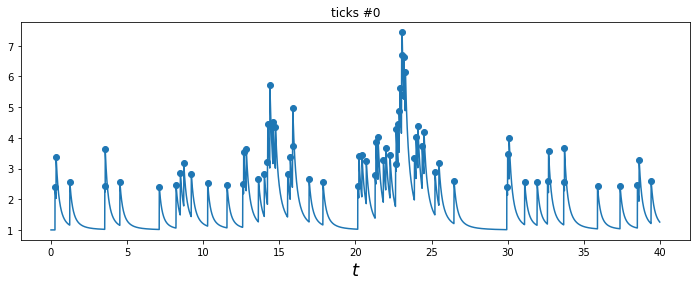

In [122]:
plot_point_process(hawkes)

### SimuHawkesMulti

In [130]:
hawkes_m = SimuHawkes(n_nodes=1, end_time=1000)
hawkes_m.set_kernel(0, 0, kernel_sumexp)
hawkes_m.set_baseline(0, 1.)

In [131]:
multi = SimuHawkesMulti(hawkes_m, n_simulations=10)
multi.simulate()

In [132]:
multi_timestamps = multi.timestamps
multi_mean_intensity = multi.mean_intensity

## Learning

#### Non-parametric

##### HawkesEM

In [ ]:
em = HawkesEM()
em.fit(multi_timestamps)

##### HawkesBasisKernels

In [ ]:
bk = HawkesBasisKernels()
bk.fit(multi_timestamps)

#### Parametric

##### HawkesSumExpKern

In [ ]:
sek = HawkesSumExpKern()
sek.fit(multi_timestamps)

##### HawkesSumGaussians

In [ ]:
sg = HawkesSumGaussians()
sg.fit(multi_timestamps)